In [1]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By

from bs4 import BeautifulSoup
from urllib.request import urlopen, Request
from user_agent import generate_user_agent
import pandas as pd

from kiwipiepy import Kiwi

from collections import Counter

import time

In [2]:
kiwi = Kiwi()

def count_word(text, word_counts):
    # kiwi.analyze()로 분석 후, 품사가 'NNG'(일반 명사), 'NNP'(고유 명사)인 경우만 추출
    nouns = [token.form for token in kiwi.analyze(text)[0][0] if token.tag.startswith('NN')]
    new_word_counts = Counter(nouns) + word_counts
    return new_word_counts

In [4]:
driver = webdriver.Chrome(service=Service("./driver/chromedriver"))

# url에 포함되어 있는 parameters
# 정렬 : sort={"0":관련도순, "1":최신순, "2":오래된순}
# 기간 : (시작기간)ds=YYYY.MM.DD, (끝기간)de=YYYY.MM.DD
# 유형 : photo={"0":전체, "1":포토, "2":동영상, "3":지면기사, ...}
# mynews=1, office_type=3, office_category=3으로 수정
company_name = "코스피"  # 검색어
date = "2003.09.22"      # 검색기간(하루로 제한 -> 추후 수정 예정)
url = f"https://search.naver.com/search.naver?ssc=tab.news.all&query={company_name}&sm=tab_opt&sort=0&photo=0&field=0&pd=3&ds={date}&de={date}&docid=&related=0&mynews=1&office_type=3&office_section_code=0&news_office_checked=&nso=so%3Ar%2Cp%3Afrom{date.replace(".","")}to{date.replace(".","")}&is_sug_officeid=0&office_category=3&service_area=0"
driver.get(url)
time.sleep(2)            # 사이트 차단 방지를 위한 멈춤

In [5]:
# 기간 내 기사들의 링크 모두 가져오기

# 모든 기사가 보일때까지 스크롤
len_before_scroll = 0
while (True):
    # 현재 로드된 뉴스 기사 목록을 모두 가져온다 (CSS 선택자는 실제 페이지에 맞게 수정)
    articles = driver.find_elements(By.CSS_SELECTOR, "div.BHQHyn3Flk5rFBSacJkG")

    # 스크롤 후 기사 수
    len_after_scroll = len(articles)

    if len(articles) > 100:
        break

    # 목록의 끝에서 두 번째 항목을 타겟으로 지정 (마지막 항목은 푸터와 겹칠 수 있음)
    if len(articles) > 1:
        target_element = articles[-2]
        
        # JavaScript를 실행하여 해당 요소가 보이도록 스크롤
        driver.execute_script("arguments[0].scrollIntoView()", target_element)

        time.sleep(1)

    # 스크롤 전후 기사 수 비교 (같다면 더이상 스크롤 할 필요 X)
    if len_before_scroll == len_after_scroll:
        break

    len_before_scroll = len_after_scroll

In [6]:
# 네이버 뉴스 주소 가져오기

news_urls = []
news_info = driver.find_elements(By.CLASS_NAME, "sds-comps-horizontal-layout.sds-comps-full-layout.sds-comps-profile.type-basic.size-lg.title-color-g10.hRlTUxpL38wmDKxyAhSU")
for info in news_info:
    news_link = info.find_element(By.CLASS_NAME, "GUWgsNcVrWa67MoYor6N.xR1x3GgF_MIcYPUZNqEu")
    news_urls.append(news_link.get_attribute("href"))

In [7]:
driver.quit()

In [8]:
def get_news_content(url):
    req = Request(url, headers={'User-Agent': generate_user_agent()})
    page = urlopen(req)
    return BeautifulSoup(page, "html.parser")

In [9]:

word_counts=Counter()
for url in news_urls:
    soup = get_news_content(url)
    time.sleep(1)
    news_title = soup.find("div", class_="media_end_head_title").find("h2")
    news_date = soup.find("span", class_="media_end_head_info_datestamp_time _ARTICLE_DATE_TIME")['data-date-time']
    # print(news_date.split(" ")[0])
    news_content = soup.find("article", class_="go_trans _article_content")

    word_counts = count_word(news_content.text, word_counts)

print(word_counts)

Counter({'수익': 29, '일': 25, '것': 19, '시장': 18, '월': 16, '주': 15, '매수': 15, '지수': 14, '계약': 14, '주가': 13, '한국전력': 12, '증권': 11, '투자': 11, '외국인': 11, '씨': 10, '면': 10, '비중': 10, '하락': 10, '원': 10, '상승': 9, '기사': 9, '물': 9, '변동': 9, '강세': 9, '종목': 8, '위': 8, '차지': 8, '평균': 8, '기자': 8, '조정': 8, '대비': 8, '환율': 8, '경기': 7, '매도': 7, '코스피': 7, '신문': 7, '등': 7, '최근': 7, '예상': 7, '애널리스트': 7, '선': 7, '유틸리티': 7, '머니투데이': 6, '누적': 6, '기관': 6, '옵션': 6, '포인트': 6, '기록': 5, '기업': 5, '주식': 5, '배당': 5, '증시': 5, '단기': 5, '선물': 5, '수혜': 5, '방어': 5, '원화': 5, '분기': 5, '분석': 5, '급락': 5, '매력': 5, '한국가스공사': 5, '투자자': 4, '추천': 4, '보유': 4, '개인': 4, '경제': 4, '말': 4, '경우': 4, '홍보': 4, '이후': 4, '미': 4, '달러': 4, '때문': 4, '상대': 4, '전망': 4, '현금': 4, '흐름': 4, '장': 4, '순매도': 4, '상품': 4, '연': 4, '고수': 3, '수': 3, '수익률': 3, '신': 3, '추가': 3, '대신증권': 3, '동원': 3, '권': 3, '중': 3, '제한': 3, '박스': 3, '차원': 3, '초': 3, '동아일보': 3, '보도': 3, '청와대': 3, '개': 3, '시': 3, '투신사': 3, '관련': 3, '국내': 3, '거래': 3, '장기': 3, '원점': 3, '지표': 3, '돌파':

In [10]:
forbidden_words = ["등", "것", "년", "월", "일", "이날", "다음", "증시", "주식", "주가",
                    "주", "배포", "장", "마감", "하락", "때", "시", "수", "중", "코스피",
                    "코스닥", "지수", "시장", "경제", "종목", "머니투데이", "기자", "최대",
                    "최소", "오전", "오후", "뉴스", "물", "위", "차지", "증권", "씨", "원"]
for word in list(word_counts.keys()):
    if word in forbidden_words:
        del word_counts[word]

In [11]:
word_counts

Counter({'수익': 29,
         '매수': 15,
         '계약': 14,
         '한국전력': 12,
         '투자': 11,
         '외국인': 11,
         '면': 10,
         '비중': 10,
         '상승': 9,
         '기사': 9,
         '변동': 9,
         '강세': 9,
         '평균': 8,
         '조정': 8,
         '대비': 8,
         '환율': 8,
         '경기': 7,
         '매도': 7,
         '신문': 7,
         '최근': 7,
         '예상': 7,
         '애널리스트': 7,
         '선': 7,
         '유틸리티': 7,
         '누적': 6,
         '기관': 6,
         '옵션': 6,
         '포인트': 6,
         '기록': 5,
         '기업': 5,
         '배당': 5,
         '단기': 5,
         '선물': 5,
         '수혜': 5,
         '방어': 5,
         '원화': 5,
         '분기': 5,
         '분석': 5,
         '급락': 5,
         '매력': 5,
         '한국가스공사': 5,
         '투자자': 4,
         '추천': 4,
         '보유': 4,
         '개인': 4,
         '말': 4,
         '경우': 4,
         '홍보': 4,
         '이후': 4,
         '미': 4,
         '달러': 4,
         '때문': 4,
         '상대': 4,
         '전망': 4,
         '

In [ ]:
word_counts=Counter()
text = '''
평화와 번영과 도약의 시대로
16대 대통령 취임사
2003년 2월 25일
존경하는 국민 여러분.
오늘 저는 대한민국의 제16대 대통령에 취임하기 위해 이 자리에 섰습니다. 국민
여러분의 위대한 선택으로, 저는 대한민국의 새 정부를 운영할 영광스러운 책임을
맡게 되었습니다.
국민 여러분께 뜨거운 감사를 올리면서, 이 벅찬 소명을 국민 여러분과 함께 완
수해 나갈 것임을 약속드립니다.
아울러 이 자리에 참석해 주신 김대중 대통령을 비롯한 전임 대통령 여러분, 고
이즈미 준이치로 일본 총리를 비롯한 세계 각국의 경축 사절과 내외 귀빈 여러분께
도 심심한 감사를 드립니다.
특별히 이 자리를 빌려, 대구 지하철 참사 희생자 여러분의 명복을 빌면서, 유가
족 여러분께도 깊은 위로를 드립니다. 다시는 이런 불행이 되풀이되지 않게, 재난관
리체계를 전면 점검하고 획기적으로 개선해 안전한 사회를 만들도록 최선을 다하겠
습니다.
국민 여러분.
우리의 역사는 도전과 극복의 연속이었습니다. 열강의 틈에 놓인 한반도에서 숱
한 고난을 이겨내고, 반만년동안 민족의 자존과 독자적 문화를 지켜왔습니다. 해방
이후에는 분단과 전쟁과 가난을 딛고, 반세기만에 세계 열두 번째의 경제 강국을
건설했습니다.
우리는 농경시대에서 산업화를 거쳐 지식정보화 시대에 성공적으로 진입했습니
다. 그러나 지금 우리는 다시 세계사적 전환점에 직면했습니다. 도약이냐 후퇴냐,
평화냐 긴장이냐의 갈림길에 서 있습니다.
세계의 안보 상황이 불안합니다. 이라크 정세가 긴박합니다. 특히 북한 핵 문제
를 둘러싼 국제사회의 우려가 고조되고 있습니다. 이럴수록 우리는 평화를 지키고
더욱 굳건히 뿌리내리게 해야 합니다. 대외 경제 환경도 어려워지고 있습니다. 선진
국들은 끝없이 새로운 영역을 개척하며 뻗어가고 있습니다. 후발국들은 무섭게 추
격해 옵니다. 우리는 새로운 성장 동력과 발전 전략을 요구받고 있습니다. 우리 사
회 내부에도 국가의 명운을 결정지을 많은 문제들이 가로놓여 있습니다. 이들 과제
는 국민 여러분의 지혜와 결단을 기다리고 있습니다.
이 모든 도전을 극복해야 합니다. 우리는 해낼 수 있습니다. 우리 국민이 힘을
합치면, 못할 것이 없습니다. 그런 저력으로 우리는 외환 위기를 세계에서 가장 빨
리 벗어났습니다. 지난해에는 월드컵 4강 신화를 창조했습니다. 대통령 선거의 모든
과정을 통해 참여 민주주의의 꽃을 피웠습니다.
존경하는 국민 여러분.
이제 우리의 미래는 한반도에 갇혀 있을 수 없습니다. 우리 앞에는 동북아 시대
가 도래하고 있습니다. 근대 이후 세계의 변방에 머물던 동북아가, 이제 세계 경제
의 새로운 활력으로 떠올랐습니다. 21세기는 동북아 시대가 될 것이라는 세계 석학
들의 예측이 착착 현실로 나타나고 있습니다. 동북아의 경제규모는 세계의 5분의 1
을 차지합니다. 한중일3국에만 유럽연합의 네 배가 넘는 인구가 살고 있습니다.
우리 한반도는 동북아의 중심에 자리잡고 있습니다. 한반도는 중국과일본, 대륙
과 해양을 연결하는 다리입니다. 이런 지정학적 위치가 지난날에는 우리에게 고통
을 주었습니다. 그러나 오늘날에는 오히려 기회를 주고 있습니다. 21세기 동북아 시
대의 중심적 역할을 우리에게 요구하고 있는 것입니다.
우리는 고급 두뇌와 창의력, 세계일류의 정보화 기반을 갖고 있습니다. 인천공항,
부산항, 광양항과 고속철도 등 하늘과 바다와 땅의 물류기반도 구비해 가고 있습니
다. 21세기 동북아 시대를 주도적으로 열어 나갈 수 있는 기본적 조건을 갖추어 가
고 있습니다. 한반도는 동북아의 물류와 금융의 중심지로 거듭날 수 있습니다.
동북아 시대는 경제에서 출발합니다. 동북아에 '번영의 공동체'를 이룩하고 이를
통해 세계의 번영에 기여해야 합니다. 그리고 언젠가는 `평화의 공동체'로 발전해야
합니다. 지금의 유럽연합과 같은 평화와 공생의 질서가 동북아에도 구축되게 하는
것이 저의 오랜 꿈입니다. 그렇게 되어야 동북아 시대는 완성됩니다. 그런 날이 가
까워지도록 저는 혼신의 노력을 다할 것임을 굳게 약속드립니다.
국민 여러분.
진정한 동북아 시대를 열자면 먼저 한반도에 평화가 제도적으로 정착되어야 합
니다. 한반도가 지구상의 마지막 냉전지대로 남은 것은 20세기의 불행한 유산입니
다. 그런 한반도가 21세기에는 세계를 향해 평화를 발신하는 평화지대로 바뀌어야
합니다. 유라시아 대륙과 태평양을 잇는 동북아의 평화로운 관문으로 새롭게 태어
나야 합니다. 부산에서 파리행 기차표를 사서 평양, 신의주, 중국, 몽골, 러시아를
거쳐 유럽의 한복판에 도착하는 날을 앞당겨야 합니다.
이제까지 우리는 한반도의 평화를 증진시키기 위해 많은 노력을 기울였습니다.
그 성과는 괄목할 만합니다. 남북한 사이에 사람과 물자의 교류가일상적인일처럼
빈번해졌습니다. 하늘과 바다와 땅의 길이 모두 열렸습니다. 그러나 정책의 추진 과
정에서는 더욱 광범위한 국민적 합의를 얻어야 한다는 과제를 남겼습니다. 저는 그
동안의 성과를 계승하고 발전시키면서 , 정책의 추진방식은 개선해 나가고자 합니다.
저는 한반도 평화증진과 공동번영을 목표로 하는 '평화번영정책'을, 몇가지 원칙
을 가지고 추진해 나가겠습니다.
첫째, 모든 현안은 대화를 통해 풀도록 하겠습니다.
둘째, 상호신뢰를 우선하고 호혜주의를 실천해 나가겠습니다.
셋째, 남북 당사자 원칙에 기초해 원활한 국제협력을 추구하겠습니다.
넷째, 대내외적 투명성을 높이고 국민참여를 확대하며 초당적 협력을 얻겠습니
다. 국민과 함께하는 '평화번영정책'이 되도록 하겠습니다.
북한의 핵무기 개발 의혹은 한반도를 비롯한 동북아와 세계의 평화에 중대한 위
협이 되고 있습니다. 북한의 핵 개발은 용인될 수 없습니다. 북한은 핵 개발 계획을
포기해야 합니다. 북한이 핵 개발 계획을 포기한다면, 국제사회는 북한이 원하는 많
은 것을 제공할 것입니다. 북한은 핵무기를 보유할 것인지, 체제안전과 경제지원을
약속받을 것인지를 선택해야 합니다.
아울러 저는 북한 핵 문제가 대화를 통해 평화적으로 해결되어야한다는 점을 거
듭 강조하고자 합니다. 어떤 형태로든 군사적 긴장이 고조되어서는 안 됩니다. 북한
핵 문제가 대화를 통해 해결되도록, 우리는 미국,일본과의 공조를 강화할 것입니다.
중국러시아유럽연합 등과도 긴밀하게 협력해 나가겠습니다.
올해는 한미동맹 50주년입니다. 한미동맹은 우리의 안전보장과 경제발전에 크게
기여해 왔습니다. 우리 국민은 이에 대해 깊이 감사하고 있습니다. 우리는 한미동맹
을 소중히 발전시켜 나갈 것입니다. 호혜평등의 관계로 더욱 성숙시켜 나갈 것입니
다. 전통우방을 비롯한 다른 국가들과의 관계도 확대해 나가겠습니다.
국민 여러분.
동북아 시대를 열고, 한반도에 평화를 정착시키려면, 우리 사회가 건강하고 미래
지향적이어야 합니다. 힘과 비전을 가져야 합니다. 그러자면 개혁과 통합을 위한 지
속적 노력이 필요합니다. 개혁은 성장의 동력이고, 통합은 도약의 디딤돌입니다.
새 정부는 개혁과 통합을 바탕으로, 국민과 함께 하는 민주주의, 더불어 사는 균
형발전사회, 평화와 번영의 동북아시대를 열어 나갈 것입니다. 이러한 목표로 가기
위해 저는 원칙과 신뢰, 공정과 투명, 대화와 타협, 분권과 자율을 새 정부 국정운
영의 좌표로 삼고자 합니다.
우리는 각 분야의 새로운 성장 동력을 창출해야 합니다. 외환위기를 초래했던 제
반 요인들은 아직도 극복해야할 과제로 남아 있습니다. 시장과 제도를 세계기준에
맞게 공정하고 투명하게 개혁해, 기업하기 좋은 나라, 투자하고 싶은 나라로 만들고
자 합니다.
정치부터 바뀌어야 합니다. 진정으로 국민이 주인인 정치가 구현되어야 합니다.
당리당략보다 국리민복을 우선하는 정치풍토가 조성되어야 합니다. 대결과 갈등이
아니라 대화와 타협으로 문제를 푸는 정치문화가 자리잡았으면 합니다. 저부터 야
당과 대화하고 타협하겠습니다.
과학기술을 부단히 혁신해 '제2의 과학기술 입국'을 이루겠습니다. 지식정보화 기
반을 지속적으로 확충하고 신산업을 육성하고자 합니다. 문화를 함양하고 문화산업
의 발전도 적극 지원하겠습니다.
이러한 국가목표에 부응할 수 있도록 교육도 혁신되어야 합니다. 우리 아이들이
입시지옥에서 벗어나 저마다의 소질과 창의력을 마음껏 발휘할 수 있게 해주어야
합니다.
경제의 지속적 성장을 위해서도, 사회의 건강을 위해서도 부정부패를 없애야 합
니다. 이를 위한 구조적 제도적 대안을 모색하겠습니다. 특히 사회지도층의 뼈를 깎
는 성찰을 요망합니다.
중앙 집권과 수도권 집중은 국가의 미래를 위해 더 이상 방치할 수 없습니다. 지
방분권과 국가균형발전은 미룰 수 없는 과제가 되었습니다. 중앙과 지방은 조화와
균형을 이루며 발전해야 합니다. 지방은 자신의 미래를 자율적으로 설계하고, 중앙
은 이를 도와야 합니다. 저는 비상한 결의로 이를 추진해 나갈 것입니다.
국민통합은 이 시대의 가장 중요한 숙제입니다. 지역구도를 완화하기 위해 새 정
부는 지역탕평 인사를 포함한 가능한 모든 조치를 취해 나갈 것입니다. 소득격차를
비롯한 계층간 격차를 좁히기 위해 교육과 세제 등의 개선을 강구하고자 합니다.
노사화합과 협력의 문화를 이루도록 노사 여러분과 함께 최선을 다하겠습니다.
노약자를 비롯한 소외받는 사람들에게 더 많은 관심을 기울이는 따뜻한 사회를
만들어야 합니다. 이를 위해 복지정책을 내실화하고자 합니다. 모든 종류의 불합리
한 차별을 없애 나가겠습니다. 양성평등사회를 지향해 나가겠습니다. 개방화 시대를
맞아 농어업과 농어민을 위한 대책을 강구하겠습니다. 고령사회의 도래에 대한 준
비에도 소홀함이 없도록 하겠습니다.
반칙과 특권이 용납되는 시대는 이제 끝나야 합니다. 정의가 패배하고 기회주의
자가 득세하는 굴절된 풍토는 청산되어야 합니다. 원칙을 바로 세워 신뢰사회를 만
듭시다. 정정당당하게 노력하는 사람이 성공하는 사회로 나아갑시다. 정직하고 성실
한 대다수 국민이 보람을 느끼게 해드려야 합니다.
존경하는 국민 여러분.
오랜 세월동안 우리는 변방의 역사를 살아왔습니다. 때로는 자신의 운명을 스스
로 결정하지 못하는 의존의 역사를 강요받기도 했습니다. 그러나 이제 우리는 새로
운 전기를 맞았습니다. 21세기 동북아 시대의 중심국가로 웅비할 기회가 우리에게
찾아 왔습니다. 우리는 이 기회를 살려 나가야 합니다.
우리에게는 수많은 도전을 극복한 저력이 있습니다. 위기마저도 기회로 만드는
지혜가 있습니다. 그런 지혜와 저력으로 오늘 우리에게 닥친 도전을 극복합시다. 오
늘 우리가 선조들을 기리는 것처럼, 먼 훗날 후손들이 오늘의 우리를 자랑스러운
조상으로 기억하게 합시다.
우리는 마음만 합치면 기적을 이루어 내는 국민입니다. 우리 모두 마음을 모읍시
다. 평화와 번영과 도약의 새 역사를 만드는 이 위대한 도정에 모두 동참합시다. 항
상 국민 여러분과 함께 하겠습니다.
감사합니다
'''

word_counts = count_word(text, word_counts)
print(word_counts)


Counter({'국민': 21, '평화': 18, '것': 18, '동북아': 18, '시대': 15, '세계': 13, '사회': 12, '한반도': 12, '수': 10, '북한': 9, '발전': 9, '번영': 8, '경제': 8, '핵': 6, '국가': 6, '세기': 6, '대화': 6, '대통령': 5, '자리': 5, '극복': 5, '문화': 5, '문제': 5, '정책': 5, '도약': 4, '감사': 4, '역사': 4, '도전': 4, '성장': 4, '과제': 4, '미래': 4, '기회': 4, '노력': 4, '추진': 4, '원칙': 4, '협력': 4, '개발': 4, '개혁': 4, '통합': 4, '정치': 4, '대': 3, '존경': 3, '정부': 3, '약속': 3, '일본': 3, '개선': 3, '안전': 3, '동안': 3, '산업': 3, '정보': 3, '국제': 3, '동력': 3, '지혜': 3, '저력': 3, '위기': 3, '유럽연합': 3, '중심': 3, '중국': 3, '날': 3, '등': 3, '제도': 3, '사람': 3, '목표': 3, '신뢰': 3, '투명': 3, '한미': 3, '동맹': 3, '타협': 3, '중앙': 3, '일': 2, '대한민국': 2, '선택': 2, '불행': 2, '최선': 2, '이후': 2, '만': 2, '지식': 2, '성공': 2, '긴장': 2, '고조': 2, '요구': 2, '힘': 2, '외환': 2, '참여': 2, '민주주의': 2, '도래': 2, '변방': 2, '대륙': 2, '시': 2, '창의력': 2, '기반': 2, '하늘': 2, '바다': 2, '땅': 2, '물류': 2, '공동체': 2, '기여': 2, '진정': 2, '정착': 2, '합': 2, '지대': 2, '러시아': 2, '증진': 2, '성과': 2, '정': 2, '우선': 2, '호혜': 2, '확대': 2, '핵무기': 2, '계획': 2, '

In [14]:
import platform
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [20]:
from PIL import Image
import numpy as np

In [22]:
word_counts

Counter({'수익': 29,
         '매수': 15,
         '계약': 14,
         '한국전력': 12,
         '투자': 11,
         '외국인': 11,
         '면': 10,
         '비중': 10,
         '상승': 9,
         '기사': 9,
         '변동': 9,
         '강세': 9,
         '평균': 8,
         '조정': 8,
         '대비': 8,
         '환율': 8,
         '경기': 7,
         '매도': 7,
         '신문': 7,
         '최근': 7,
         '예상': 7,
         '애널리스트': 7,
         '선': 7,
         '유틸리티': 7,
         '누적': 6,
         '기관': 6,
         '옵션': 6,
         '포인트': 6,
         '기록': 5,
         '기업': 5,
         '배당': 5,
         '단기': 5,
         '선물': 5,
         '수혜': 5,
         '방어': 5,
         '원화': 5,
         '분기': 5,
         '분석': 5,
         '급락': 5,
         '매력': 5,
         '한국가스공사': 5,
         '투자자': 4,
         '추천': 4,
         '보유': 4,
         '개인': 4,
         '말': 4,
         '경우': 4,
         '홍보': 4,
         '이후': 4,
         '미': 4,
         '달러': 4,
         '때문': 4,
         '상대': 4,
         '전망': 4,
         '

In [31]:
img_data = Image.open("data/bubble.png").convert("RGBA")
width, height = img_data.size
white_bg = Image.new("RGBA", (width, height), (255, 255, 255, 255))
white_bg.paste(img_data, (0, 0), img_data)
bubble_mask = np.array(white_bg)

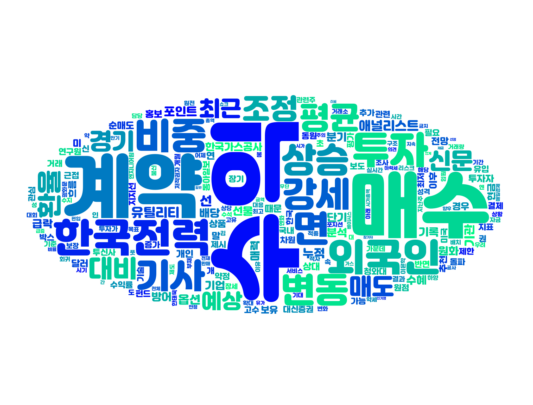

In [ ]:
# 2. 한글 폰트 경로 설정 (운영체제에 맞게)
# Windows: C:/Windows/Fonts/malgun.ttf
# macOS: /System/Library/Fonts/AppleSDGothicNeo.ttc
# Ubuntu: /usr/share/fonts/truetype/nanum/NanumGothic.ttf (설치 필요)
system_name = platform.system()
if system_name == 'Windows':
    font_path = 'C:/Windows/Fonts/malgun.ttf'
elif system_name == 'Darwin':
    font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
elif system_name == 'Linux':
    # 폰트가 설치되어 있는지 확인 후, 경로를 지정해야 합니다.
    # sudo apt-get install fonts-nanum*
    font_path = '/usr/share/fonts/truetype/nanum/Nanum'
else:
    font_path = None

# bubble_mask = np.array(Image.open("data/bubble.png"))
# bubble_mask = 255-bubble_mask

# 3. 워드 클라우드 객체 생성 및 빈도수 데이터로 생성
wordcloud = WordCloud(
    mask = np.array(Image.open("data/ellipse.png")),
    font_path=font_path,
    width=800,
    height=400,
    background_color='white',
    colormap="winter"
).generate_from_frequencies(word_counts)


# 4. 이미지 표시
plt.figure(figsize=(10, 5)) # 이미지 크기 설정
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off') # 축 숨기기
plt.show()

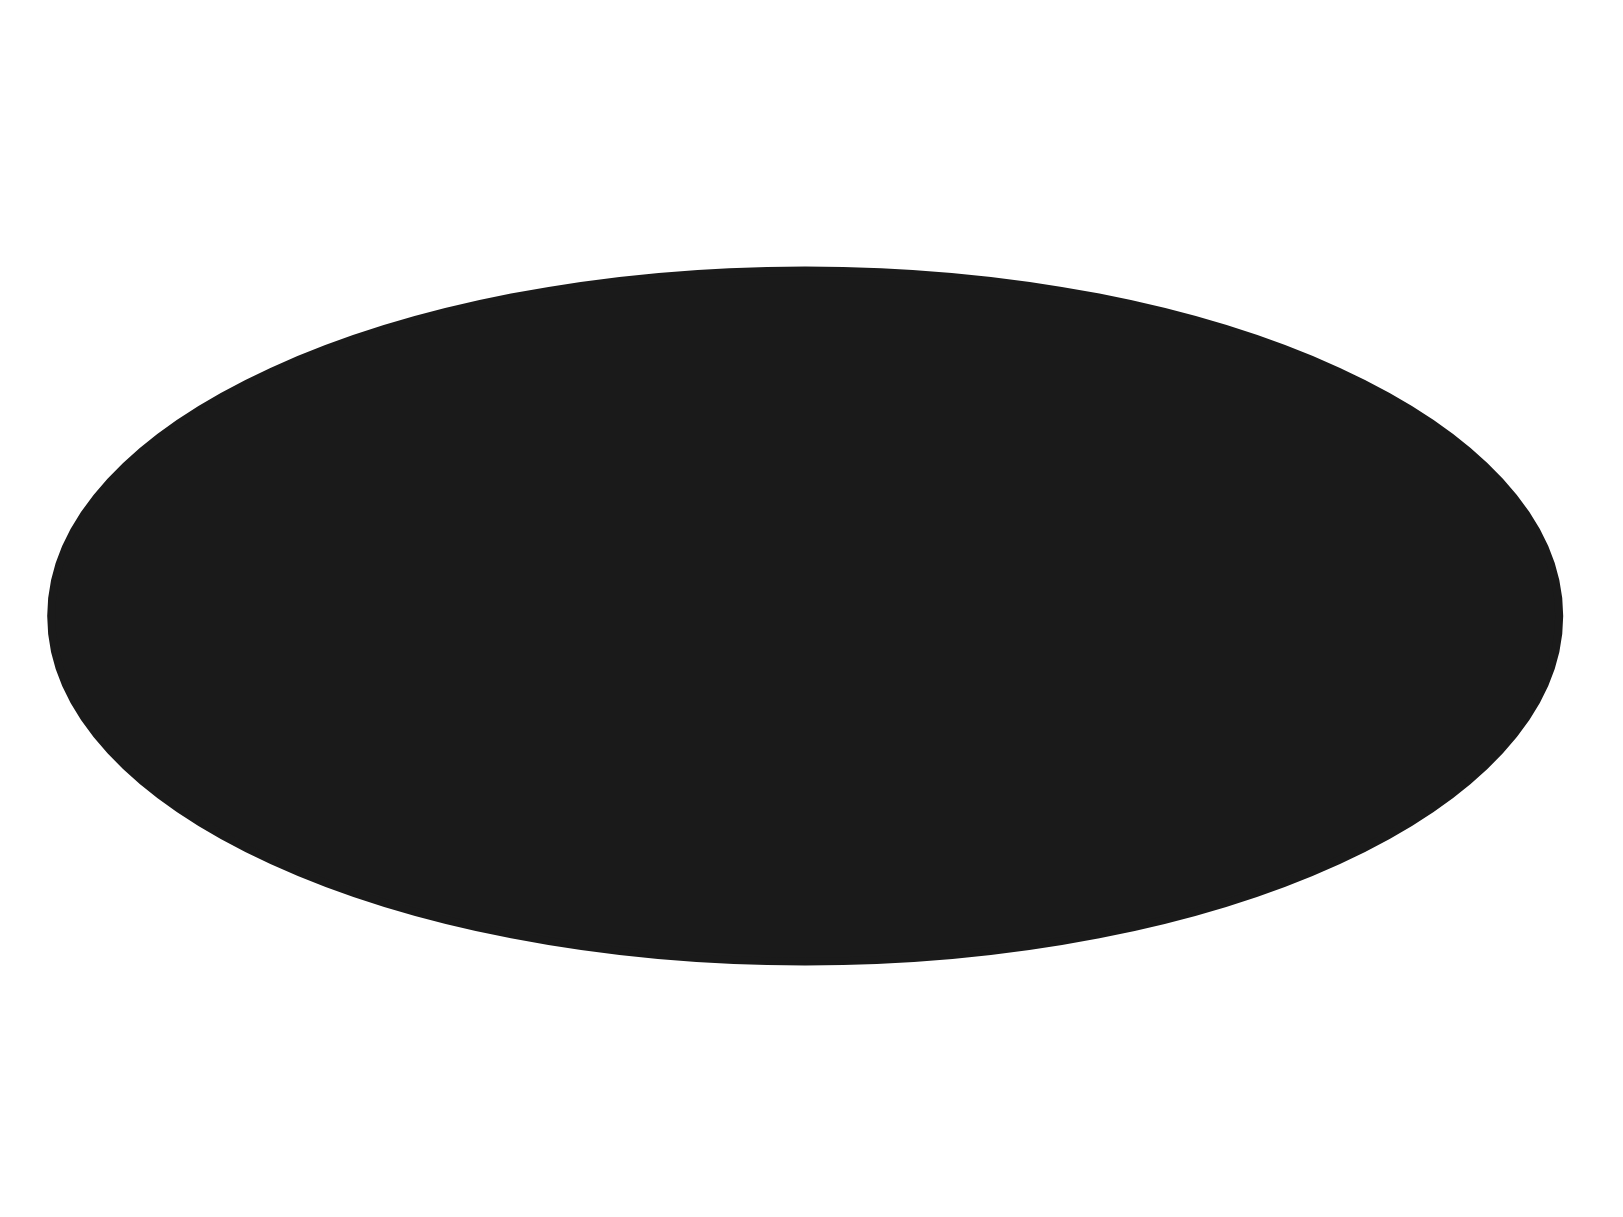

In [36]:
Image.open("data/ellipse.png")